In [2]:
import pandas as pd
import numpy as np
import six
from six.moves import cPickle as cpik
import tensorflow as tf
import keras
from keras.models import load_model
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.layers.recurrent import LSTM,GRU
from keras import backend as K
from timeit import default_timer as timer
from sklearn.grid_search import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
import six
from six.moves import cPickle as cpik

/Users/michael.zhang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/michael.zhang/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/michael.zhang/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all

### 1- Functions of reading Data, accuracy measures, etc.

In [3]:
def build_dl_dataset_by_ts(df, ts):
    '''
    Build up a (data_size * 11 * 7 * 7 * 2) dataset for both traning and testing
    
    Input
    df: a dateframe
    ts: time_steps, use how many previous time frame to predict the next one, e.g., if it is 11, then use the
        previous 11 date to predict current 1.
    
    Output
    Training set and testing set
    
    '''
    fids = df['FishnetID'].unique().tolist()
    #print(fids)
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []
    
    for fid in fids:
        df_current = df[df['FishnetID'] == fid].reset_index(drop = True) #original dataset has been ordered by time.
        df_current_len = df_current.shape[0] # overall length of current data 
        if (df_current_len - ts - 1)>0:
            for i in range(df_current_len - ts - 1):
                # current slice of input data
                X_train_cur = []
                Y_train_cur = []
                # append every X by time steps
                for x_v in df_current['neighbours_index_image'].iloc[i : (i+ts)].values:
                    X_train_cur.append(x_v)
                    #print(np.array(X_cur).shape)    
                X_train.append(np.array(X_train_cur))  
                # append very Y by time steps
                for y_v in df_current['PerformanceTarget'].iloc[i+1 : (i+ts+1)].values:
                    Y_train_cur.append(y_v)
                Y_train.append(np.array(Y_train_cur))
            
            for i in range(df_current_len - ts - 1, df_current_len - ts):
                # current slice of input data
                X_test_cur = []
                Y_test_cur = []
                # append every X by time steps
                for x_v in df_current['neighbours_index_image'].iloc[i : (i+ts)].values:
                    X_test_cur.append(x_v)
                    #print(np.array(X_cur).shape)
                X_test.append(np.array(X_test_cur))  
                # append very Y by time steps
                for y_v in df_current['PerformanceTarget'].iloc[i+1 : ].values:
                    Y_test_cur.append(y_v)
                Y_test.append(np.array(Y_test_cur))
        else:
            for i in range(df_current_len - ts):
                # current slice of input data
                X_cur = []
                Y_cur = []
                # append every X by time steps
                for x_v in df_current['neighbours_index_image'].iloc[i : (i+ts)].values:
                    X_cur.append(x_v)
                    #print(np.array(X_cur).shape)    
                X_train.append(np.array(X_cur))
                X_test.append(np.array(X_cur))  
                # append very Y by time steps
                for y_v in df_current['PerformanceTarget'].iloc[i+1 : (i+ts+1)].values:
                    Y_cur.append(y_v)
                Y_train.append(np.array(Y_cur))
                Y_test.append(np.array(Y_cur))      
    return (X_train, Y_train, X_test, Y_test)




#MAPE loss function self defined for keras
def mape_loss(y_true, y_pred):
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true),
                                            K.epsilon(),
                                            None))
    return 100. * K.mean(diff, axis=-1)


# MAPE loss for calculate test result.
def mape(y_p, y):
    y[y == 0] = 0.00001
    diff = np.abs((y_p - y) / y)
    #print(diff)
    return 100. * np.mean(diff)



# RMSE loss for calculate test result.
def rmse(y_p, y):
    diff = np.sqrt((y_p - y)**2)# np.sum()
    return np.mean(diff)


def moving_avg(df, ts):
    '''
    Build up moving average model
    
    Input
    df: a dateframe
    ts: time_steps, use how many previous time frame to predict the next one, e.g., if it is 11, then use the
        previous 11 date to predict current 1.
    
    Output
    Error of MAPE and RMSE
    
    '''
    fids = df['FishnetID'].unique().tolist()
    #print(fids)
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []
    
    for fid in fids:
        df_current = df[df['FishnetID'] == fid].reset_index(drop = True) #original dataset has been ordered by time.
        df_current_len = df_current.shape[0] # overall length of current data 
        if (df_current_len - ts - 1)>0:
            for i in range(df_current_len - ts - 1):
                # current slice of input data
                X_train_cur = []
                Y_train_cur = []
                # append every X by time steps
                for x_v in df_current['PerformanceTarget'].iloc[i : (i+ts)].values:
                    X_train_cur.append(x_v)
                    #print(np.array(X_cur).shape)
                #print(X_train_cur)
                X_train.append(np.array(np.mean(X_train_cur)))  
                # append very Y by time steps
                for y_v in df_current['PerformanceTarget'].iloc[i+1 : (i+ts+1)].values:
                    Y_train_cur.append(y_v)
                #print('Ytrain:  ', Y_train_cur)
                Y_train.append(np.array(Y_train_cur[-1]))
            
            for i in range(df_current_len - ts - 1, df_current_len - ts):
                # current slice of input data
                X_test_cur = []
                Y_test_cur = []
                # append every X by time steps
                for x_v in df_current['PerformanceTarget'].iloc[i : (i+ts)].values:
                    X_test_cur.append(x_v)
                    #print(np.array(X_cur).shape)
                X_test.append(np.array(np.mean(X_test_cur)))  
                # append very Y by time steps
                for y_v in df_current['PerformanceTarget'].iloc[i+1 : ].values:
                    Y_test_cur.append(y_v)
                Y_test.append(np.array(Y_test_cur[-1]))
        else:
            for i in range(df_current_len - ts):
                # current slice of input data
                X_cur = []
                Y_cur = []
                # append every X by time steps
                for x_v in df_current['PerformanceTarget'].iloc[i : (i+ts)].values:
                    X_cur.append(x_v)
                    #print(np.array(X_cur).shape)    
                X_train.append(np.array(X_cur))
                X_test.append(np.array(X_cur))  
                # append very Y by time steps
                for y_v in df_current['PerformanceTarget'].iloc[i+1 : (i+ts+1)].values:
                    Y_cur.append(y_v)
                Y_train.append(np.array(Y_cur[-1]))
                Y_test.append(np.array(Y_cur[-1]))      
    
    
    X_train = np.nan_to_num(np.array(X_train))
    Y_train = np.nan_to_num(np.array(Y_train))
    X_test = np.nan_to_num(np.array(X_test))
    Y_test = np.nan_to_num(np.array(Y_test))
    #print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)
    #print((X_train - Y_train).shape)
    traing_error_mape = mape(X_train, Y_train)
    testing_error_mape = mape(X_test, Y_test)
    
    traing_error_rmse = rmse(X_train, Y_train)
    testing_error_rmse = rmse(X_test, Y_test)
    
    return (traing_error_mape, testing_error_mape, traing_error_rmse, testing_error_rmse)


In [4]:
# def CNN_LSTM_MODEL_RMSprop
def cnn_on_lstm_rms_model(CONV2D_1_DEPTH, CONV2D_2_DEPTH, CNN_DP, #CNN archi related
                          LSTM_DP, LSTM_UNITS, #LSTM archi related# RMSprop related
                          inputshapes, loss_fnc):
    model = Sequential()
    # add two time-distributed convolutional layers for feature extraction
    model.add(TimeDistributed(Conv2D(CONV2D_1_DEPTH, (3, 3), activation='relu'), input_shape = inputshapes))
    #model.add(TimeDistributed(Conv2D(16, (4, 4), activation='relu')))
    model.add(TimeDistributed(Conv2D(CONV2D_2_DEPTH, (5, 5), activation='relu')))


    # extract features and dropout 
    model.add(TimeDistributed(Flatten()))
    model.add(Dropout(CNN_DP))
    #print(123123123)
    # input to LSTM
    model.add(LSTM(LSTM_UNITS, return_sequences=True, dropout=LSTM_DP)) #input_shape=(5, 512), 
    #print(123123123)
    # classifier with sigmoid activation for multilabel
    model.add(Dense(1, activation='tanh'))
    #model.add(TimeDistributed(Dense(1, activation='tanh')))

    # compile the model with binary_crossentropy loss for multilabel
    #Rmsprop = keras.optimizers.RMSprop(lr=RMSprop_LR, rho=RMSprop_RHO, 
    #                                   epsilon=None, decay=RMSprop_DECAY)
    #model.compile(optimizer= Rmsprop, loss = loss_fnc)
    #keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    model.compile(optimizer= 'rmsprop', loss = mape_loss)
    # look at the params before training
    #model.summary()
    return model

In [5]:
def get_performance(num_interates, X_train, Y_train, X_test, Y_test):
    
    inputshapes = X_train.shape[1:]
    cnnlstm_train_mape = []
    cnnlstm_test_mape = []
    cnnlstm_train_rmse= []
    cnnlstm_test_rmse =[]
    
    cnnlstm_train_error_85 = []
    cnnlstm_test_error_85 = []
    
    for i in range(num_interates):
        cnnlstm = cnn_on_lstm_rms_model(64, 64, 0.1, 0.1, 64, inputshapes, mape_loss)
        cnnlstm.fit(X_train, Y_train, batch_size = 64,epochs=50,verbose=0) #
        
        # prediction
        Y_train_pred = cnnlstm.predict(X_train)
        Y_test_pred = cnnlstm.predict(X_test)
        
        Y_train_pred = Y_train_pred[:,-1,:].flatten()
        Y_train_true = Y_train[:,-1,:].flatten()
        Y_test_pred = Y_test_pred[:,-1,:].flatten()
        Y_test_true = Y_test[:,-1,:].flatten()
        
        # mape train
        cnnlstm_train_mape.append(mape(Y_train_pred, Y_train_true))
        # mape test
        cnnlstm_test_mape.append(mape(Y_test_pred, Y_test_true))
        # rmse train
        cnnlstm_train_rmse.append(rmse(Y_train_pred, Y_train_true))
        # rmse test
        cnnlstm_test_rmse.append(rmse(Y_test_pred, Y_test_true)) 
        
        cnnlstm_train_error_85.append(Y_train_pred[Y_train_true<0.85] - Y_train_true[Y_train_true<0.85])
        cnnlstm_test_error_85.append(Y_test_true[Y_test_true<0.85] - Y_test_true[Y_test_true<0.85])
    
        if i%10 ==0:
            print('Finished {} times'.format(i))
    
    return(cnnlstm_train_mape, cnnlstm_test_mape, cnnlstm_train_rmse, 
           cnnlstm_test_rmse, cnnlstm_train_error_85, cnnlstm_test_error_85)

In [6]:
#global vars time step
ts = 3

##  1- Hospitilaty

   ### (3, 64, 64, 0.1, 0.1, 16)

In [6]:
hos_df = pd.read_csv('3_hospitality_13months.csv').iloc[:, 1:8]

neighbours_index_image_arys = cpik.load(open("3_hospitality_13months.pkl", "rb" ))
hos_df['neighbours_index_image'] = neighbours_index_image_arys.tolist()
hos_df['neighbours_index_image'] = hos_df['neighbours_index_image'].apply(lambda x : np.array(x))
print(hos_df['neighbours_index_image'].shape, hos_df['neighbours_index_image'].iloc[0].shape)
ts = 3

(4459,) (7, 7, 2)


In [7]:
# Build up dateset
X_train_hos, Y_train_hos, X_test_hos, Y_test_hos= build_dl_dataset_by_ts(hos_df, ts)
X_train_hos = np.array(X_train_hos)
X_train_hos= np.nan_to_num(X_train_hos)

Y_train_hos = np.array(Y_train_hos)
Y_train_hos = Y_train_hos.reshape(Y_train_hos.shape[0],Y_train_hos.shape[1],1)
Y_train_hos= np.nan_to_num(Y_train_hos)


X_test_hos = np.array(X_test_hos)
X_test_hos= np.nan_to_num(X_test_hos)

Y_test_hos = np.array(Y_test_hos)
Y_test_hos = Y_test_hos.reshape(Y_test_hos.shape[0],Y_test_hos.shape[1],1)
Y_test_hos= np.nan_to_num(Y_test_hos)

In [8]:
print(X_train_hos.shape, Y_train_hos.shape, X_test_hos.shape, Y_test_hos.shape)

(3087, 3, 7, 7, 2) (3087, 3, 1) (343, 3, 7, 7, 2) (343, 3, 1)


In [ ]:
inputshapes = X_train.shape[1:]
cnnlstm = cnn_on_lstm_rms_model(64, 64, 0.1, 0.1, 64, inputshapes, mape_loss)
cnnlstm.fit(X_train_hos, Y_train_hos, batch_size = 64,epochs=50,verbose=0) #
Y_train_hos_pred = cnnlstm.predict(X_train_hos)
Y_test_hos_pred = cnnlstm.predict(X_test_hos)

Y_train_hos_pred = Y_train_hos_pred[:,-1,:].flatten()
Y_train_hos_true = Y_train_hos[:,-1,:].flatten()
Y_test_hos_pred = Y_test_hos_pred[:,-1,:].flatten()
Y_test_hos_true = Y_test_hos[:,-1,:].flatten()

# mape train
hos_train_mape = mape(Y_train_hos_pred, Y_train_hos_true)

# mape test
hos_test_mape = mape(Y_test_hos_pred, Y_test_hos_true)


# rmse train
hos_train_rmse = rmse(Y_train_hos_pred, Y_train_hos_true)

# rmse test
hos_test_rmse = rmse(Y_test_hos_pred, Y_test_hos_true)

In [51]:
hos_train_mape, hos_test_mape, hos_train_rmse, hos_test_rmse

(3.0169203202917574,
 6.190152465428925,
 0.02292676258583767,
 0.03423888835100669)

In [72]:
hos_train_mape, hos_test_mape, hos_train_rmse, \
hos_test_rmse, hos_train_error85, hos_test_error85 = \
get_performance(20, X_train_hos, Y_train_hos, X_test_hos, Y_test_hos)

Finished 0 times
Finished 10 times


2.703154065145557


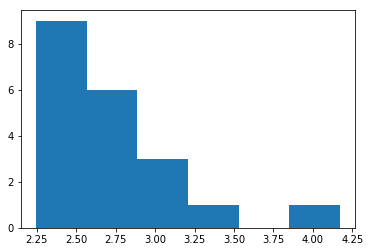

DescribeResult(nobs=20, minmax=(2.242914661978071, 4.173388519962724), mean=2.703154065145557, variance=0.20497203783317425, skewness=1.8214375043593547, kurtosis=3.5450425530369447)

In [73]:
from matplotlib import pyplot as plt
from scipy import stats
#hos_train_mape_new = [hos_train_mape[i] for i in range(0,len(hos_train_mape),4)]
print(np.mean(hos_train_mape))
plt.hist(np.array(hos_train_mape), bins='auto')
plt.show()
stats.describe(hos_train_mape)

0.020708005536281254


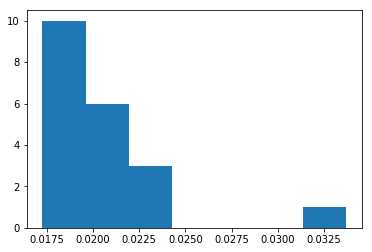

DescribeResult(nobs=20, minmax=(0.01725750530769341, 0.03370356811507837), mean=0.020708005536281254, variance=1.3478949783456568e-05, skewness=2.2961396194731902, kurtosis=5.910635406328375)

In [74]:
print(np.mean(hos_train_rmse))
plt.hist(np.array(hos_train_rmse), bins='auto')
plt.show()
stats.describe(hos_train_rmse)

In [75]:
#t = hos_train_error85[3]
#t[(t>0.1) | (t<-0.1)].shape, t.shape

k = [hos_train_error85[i][(hos_train_error85[i]>0.1) | (hos_train_error85[i]<-0.1)].shape[0] for i in range(len(hos_train_error85))]

np.mean(k)

66.05

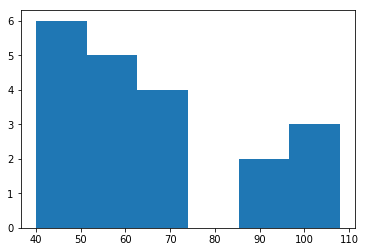

In [76]:
plt.hist(k, bins='auto')
plt.show()

In [98]:
np.median(k)

55.5

In [79]:
cpik.dump(hos_train_mape, open( "inside compare/hos/20/2_Hospitality_2channel_mape.pkl", "wb" )) 
cpik.dump(hos_train_rmse, open( "inside compare/hos/20/2_Hospitality_2channel_rmse.pkl", "wb" )) 
cpik.dump(hos_train_error85, open( "inside compare/hos/20/2_Hospitality_2channel_error85.pkl", "wb" )) 

##  2- Retail

   ### (3, 64, 64, 0.1, 0.1, 16)

In [80]:
ret_df = pd.read_csv('4_retail_13months.csv').iloc[:, 1:8]

neighbours_index_image_arys = cpik.load(open("4_retail_13months.pkl", "rb" ))
ret_df['neighbours_index_image'] = neighbours_index_image_arys.tolist()
ret_df['neighbours_index_image'] = ret_df['neighbours_index_image'].apply(lambda x : np.array(x))
print(ret_df['neighbours_index_image'].shape, ret_df['neighbours_index_image'].iloc[0].shape)
ts = 3

(4212,) (7, 7, 2)


In [83]:
# Build up dateset
X_train_ret, Y_train_ret, X_test_ret, Y_test_ret= build_dl_dataset_by_ts(ret_df, ts)
X_train_ret = np.array(X_train_ret)
X_train_ret = np.nan_to_num(X_train_ret)

Y_train_ret = np.array(Y_train_ret)
Y_train_ret = Y_train_ret.reshape(Y_train_ret.shape[0],Y_train_ret.shape[1],1)
Y_train_ret = np.nan_to_num(Y_train_ret)


X_test_ret = np.array(X_test_ret)
X_test_ret = np.nan_to_num(X_test_ret)

Y_test_ret = np.array(Y_test_ret)
Y_test_ret = Y_test_ret.reshape(Y_test_ret.shape[0],Y_test_ret.shape[1],1)
Y_test_ret = np.nan_to_num(Y_test_ret)

In [84]:
print(X_train_ret.shape, Y_train_ret.shape, X_test_ret.shape, Y_test_ret.shape)

(2916, 3, 7, 7, 2) (2916, 3, 1) (324, 3, 7, 7, 2) (324, 3, 1)


In [93]:
inputshapes = X_train_ret.shape[1:]


cnnlstm = cnn_on_lstm_rms_model(64, 64, 0.1, 0.1, 16, inputshapes, mape_loss)
cnnlstm.fit(X_train_ret, Y_train_ret, batch_size = 64,epochs=50,verbose=0) #

Y_train_ret_pred = cnnlstm.predict(X_train_ret)
Y_test_ret_pred = cnnlstm.predict(X_test_ret)

Y_train_ret_pred = Y_train_ret_pred[:,-1,:].flatten()
Y_train_ret_true = Y_train_ret[:,-1,:].flatten()

Y_test_ret_pred = Y_test_ret_pred[:,-1,:].flatten()
Y_test_ret_true = Y_test_ret[:,-1,:].flatten()


# mape train
ret_train_mape = mape(Y_train_ret_pred, Y_train_ret_true)

# mape test
ret_test_mape = mape(Y_test_ret_pred, Y_test_ret_true)


# rmse train
ret_train_rmse = rmse(Y_train_ret_pred, Y_train_ret_true)

# rmse test
rettest_rmse = rmse(Y_test_ret_pred, Y_test_ret_true)

In [94]:
ret_train_mape, ret_test_mape, ret_train_rmse, ret_test_rmse

(2.711875260565852,
 2.8227164940865146,
 0.019935022065072066,
 0.020797210968718116)

In [104]:
ret_train_mape, ret_test_mape, ret_train_rmse, \
ret_test_rmse, ret_train_error85, ret_test_error85 \
    = get_performance(30, X_train_ret, Y_train_ret, X_test_ret, Y_test_ret)

Finished 0 times
Finished 10 times
Finished 20 times


2.306390063472664


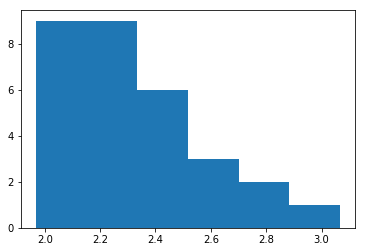

DescribeResult(nobs=30, minmax=(1.9674450356676982, 3.0673216904186362), mean=2.306390063472664, variance=0.06152238483274829, skewness=1.131890128062156, kurtosis=1.22502971067175)

In [105]:
from matplotlib import pyplot as plt
from scipy import stats
#hos_train_mape_new = [hos_train_mape[i] for i in range(0,len(hos_train_mape),4)]
print(np.mean(ret_train_mape))
plt.hist(np.array(ret_train_mape), bins='auto')
plt.show()
stats.describe(ret_train_mape)

0.017635046479563952


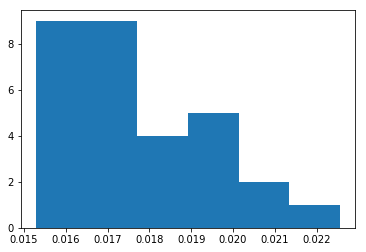

DescribeResult(nobs=30, minmax=(0.015285113720834992, 0.022561130830747764), mean=0.017635046479563952, variance=3.1532045495810646e-06, skewness=0.8974838800605962, kurtosis=0.18316472797570116)

In [106]:
print(np.mean(ret_train_rmse))
plt.hist(np.array(ret_train_rmse), bins='auto')
plt.show()
stats.describe(ret_train_rmse)

In [107]:
#t = hos_train_error85[3]
#t[(t>0.1) | (t<-0.1)].shape, t.shape

k = [ret_train_error85[i][(ret_train_error85[i]>0.1) | (ret_train_error85[i]<-0.1)].shape[0] for i in range(len(ret_train_error85))]

np.mean(k)

56.13333333333333

In [108]:
np.median(hos_train_mape)

2.6004395573720807

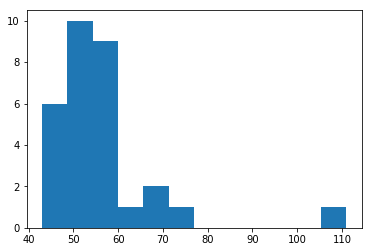

In [109]:
plt.hist(k, bins='auto')
plt.show()

In [110]:
cpik.dump(ret_train_mape, open( "inside compare/ret/30/2_Retail_2channel_mape.pkl", "wb" )) 
cpik.dump(ret_train_rmse, open( "inside compare/ret/30/2_Retail_2channel_rmse.pkl", "wb" )) 
cpik.dump(ret_train_error85, open( "inside compare/ret/30/2_Retail_2channel_error85.pkl", "wb" )) 

##  3- Building

   ### (3, 128, 64, 0.1, 0.1, 64)

In [7]:
bud_df = pd.read_csv('1_building_13months.csv').iloc[:, 1:8]

neighbours_index_image_arys = cpik.load(open("1_building_13months.pkl", "rb" ))
bud_df['neighbours_index_image'] = neighbours_index_image_arys.tolist()
bud_df['neighbours_index_image'] = bud_df['neighbours_index_image'].apply(lambda x : np.array(x))
print(bud_df['neighbours_index_image'].shape, bud_df['neighbours_index_image'].iloc[0].shape)
ts = 3

(4498,) (7, 7, 2)


In [8]:
# Build up dateset
X_train_bud, Y_train_bud, X_test_bud, Y_test_bud= build_dl_dataset_by_ts(bud_df, ts)
X_train_bud = np.array(X_train_bud)
X_train_bud = np.nan_to_num(X_train_bud)

Y_train_bud = np.array(Y_train_bud)
Y_train_bud = Y_train_bud.reshape(Y_train_bud.shape[0],Y_train_bud.shape[1],1)
Y_train_bud = np.nan_to_num(Y_train_bud)


X_test_bud = np.array(X_test_bud)
X_test_bud = np.nan_to_num(X_test_bud)

Y_test_bud = np.array(Y_test_bud)
Y_test_bud = Y_test_bud.reshape(Y_test_bud.shape[0],Y_test_bud.shape[1],1)
Y_test_bud = np.nan_to_num(Y_test_bud)

In [9]:
print(X_train_bud.shape, Y_train_bud.shape, X_test_bud.shape, Y_test_bud.shape)

(3114, 3, 7, 7, 2) (3114, 3, 1) (346, 3, 7, 7, 2) (346, 3, 1)


In [107]:
inputshapes = X_train_bud.shape[1:]


cnnlstm = cnn_on_lstm_rms_model(64, 64, 0.1, 0.1, 64, inputshapes, mape_loss)
cnnlstm.fit(X_train_bud, Y_train_bud, batch_size = 64,epochs=50,verbose=0) #


Y_train_bud_pred = cnnlstm.predict(X_train_bud)
Y_test_bud_pred = cnnlstm.predict(X_test_bud)

Y_train_bud_pred = Y_train_bud_pred[:,-1,:].flatten()
Y_train_bud_true = Y_train_bud[:,-1,:].flatten()
Y_test_bud_pred = Y_test_bud_pred[:,-1,:].flatten()
Y_test_bud_true = Y_test_bud[:,-1,:].flatten()


# mape train

bud_train_mape = mape(Y_train_bud_pred, Y_train_bud_true)

# mape test
bud_test_mape = mape(Y_test_bud_pred, Y_test_bud_true)


# rmse train
bud_train_rmse = rmse(Y_train_bud_pred, Y_train_bud_true)

# rmse test
bud_test_rmse = rmse(Y_test_bud_pred, Y_test_bud_true)

In [108]:
bud_train_mape, bud_test_mape, bud_train_rmse, bud_test_rmse

(3.716196248868705,
 5.452809844697034,
 0.026411421955933382,
 0.0401412817018225)

In [10]:
bud_train_mape, bud_test_mape, bud_train_rmse,\
bud_test_rmse, bud_train_error85, bud_test_error85 \
       = get_performance(30, X_train_bud, Y_train_bud, X_test_bud, Y_test_bud)

Finished 0 times
Finished 10 times
Finished 20 times


In [11]:
from matplotlib import pyplot as plt
from scipy import stats
#hos_train_mape_new = [hos_train_mape[i] for i in range(0,len(hos_train_mape),4)]
print(np.mean(bud_train_mape))
plt.hist(np.array(bud_train_mape), bins='auto')
plt.show()
stats.describe(bud_train_mape)

3.4098186545509375


DescribeResult(nobs=30, minmax=(2.8778061157876165, 4.406277331726864), mean=3.4098186545509375, variance=0.17972742066099684, skewness=0.9857514943576761, kurtosis=-0.09690075874465087)

0.02357149083470078


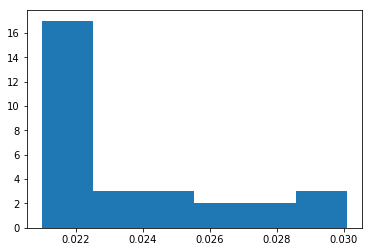

DescribeResult(nobs=30, minmax=(0.021000602653750873, 0.030084812385812357), mean=0.02357149083470078, variance=7.931497147375337e-06, skewness=1.0735276852280349, kurtosis=-0.0847165759792885)

In [12]:
print(np.mean(bud_train_rmse))
plt.hist(np.array(bud_train_rmse), bins='auto')
plt.show()
stats.describe(bud_train_rmse)

In [13]:

k = [bud_train_error85[i][(bud_train_error85[i]>0.1) | (bud_train_error85[i]<-0.1)].shape[0] for i in range(len(bud_train_error85))]

np.mean(k)

71.66666666666667

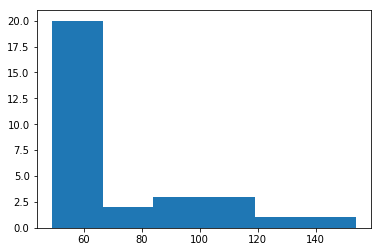

In [14]:
plt.hist(k, bins='auto')
plt.show()

In [16]:
cpik.dump(bud_train_mape, open( "inside compare/bud/30/2_Retail_2channel_mape.pkl", "wb" )) 
cpik.dump(bud_train_rmse, open( "inside compare/bud/30/2_Retail_2channel_rmse.pkl", "wb" )) 
cpik.dump(bud_train_error85, open( "inside compare/bud/30/2_Retail_2channel_error85.pkl", "wb" )) 

#  Result plot


In [52]:
def dl_result(df, ts, Y_train, Y_test):
    '''
    Concate the prediction result from DL model
    
    '''
    
    
    fids = df['FishnetID'].unique().tolist()
    len_fids = len(fids)
    df['dl_avg_pred'] = 0
    s = i = 0
    train_idx_span = int(Y_train.shape[0] / len_fids)
    for fid in fids:
        df_current = df[df['FishnetID'] == fid].reset_index(drop = True)
        df_current_len = df_current.shape[0]
        #print(s,df_current_len,train_idx_span)
        if (df_current_len - ts - 1)>0:
            #for i in range(train_idx_span):
            #print((ts + s*df_current_len + train_idx_span))
            #print(Y_train[s*9:(s+1)*train_idx_span])
            df['dl_avg_pred'].iloc[(ts + s*df_current_len): 
                                   (ts + s*df_current_len + train_idx_span)] = Y_train[s*9:(s+1)*train_idx_span]
            # testing result
            #print(Y_test[s])
            df['dl_avg_pred'].iloc[ts + s*df_current_len + train_idx_span] = Y_test[s]
                
        elif (df_current_len - ts - 1)==0:
            # training result
            df['dl_avg_pred'].iloc[(ts + s*df_current_len): 
                                   (ts + (s+1)*train_idx_span)] = Y_train[s*9:(s+1)*train_idx_span]
            # testing result
            df['dl_avg_pred'].iloc[ts + (s+1)*train_idx_span] = Y_test[s]
                
        else:
            print('data size too less than assigned time step')
        
        s = s+1
        i = i+1
        
    return df

##  1. host

In [54]:
hos_df_result = dl_result(hos_df, ts, Y_train_pred, Y_test_pred)


/Users/michael.zhang/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [57]:
hos_df_result_085 = hos_df_result[(hos_df_result['PerformanceTarget'] <=0.85 )][['FishnetID','ReportingMonth',
                                                                             'PerformanceTarget',
                                                                             'dl_avg_pred']]

In [61]:
hos_df_result_085['df_error'] = hos_df_result_085['dl_avg_pred'] - hos_df_result_085['PerformanceTarget']


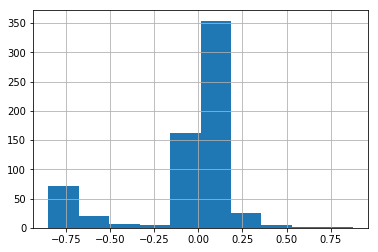

In [63]:
hos_df_result_085['df_error'].hist()

In [64]:
hos_df_result_085.to_csv('hos_df_result_085.csv')

##  2. Retail

In [95]:
ret_df_result = dl_result(ret_df, ts, Y_train_pred, Y_test_pred)

/Users/michael.zhang/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [96]:
ret_df_result_085 = ret_df_result[(ret_df_result['PerformanceTarget'] <=0.85 )][['FishnetID','ReportingMonth',
                                                                             'PerformanceTarget',
                                                                             'dl_avg_pred']]
ret_df_result_085['df_error'] = ret_df_result_085['dl_avg_pred'] - ret_df_result_085['PerformanceTarget']

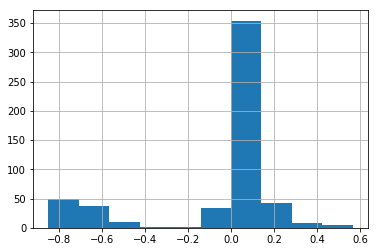

In [98]:
ret_df_result_085['df_error'].hist()

In [99]:
ret_df_result_085.to_csv('ret_df_result_085_1_channel.csv')

## 3.Building

In [109]:
bud_df_result = dl_result(bud_df, ts, Y_train_pred, Y_test_pred)

/Users/michael.zhang/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [110]:
bud_df_result_085 = bud_df_result[(bud_df_result['PerformanceTarget'] <=0.85 )][['FishnetID','ReportingMonth',
                                                                             'PerformanceTarget',
                                                                             'dl_avg_pred']]
bud_df_result_085['df_error'] = bud_df_result_085['dl_avg_pred'] - bud_df_result_085['PerformanceTarget']

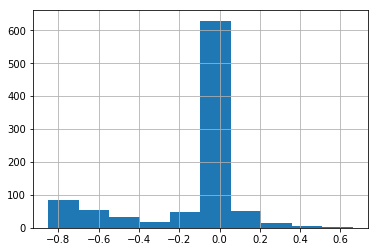

In [111]:
bud_df_result_085['df_error'].hist()

In [112]:
bud_df_result_085.to_csv('bud_df_result_085_1_channel.csv')

In [114]:
bud_df_result_085[(bud_df_result_085['df_error'] >=0.1) | (bud_df_result_085['df_error']<= -0.1)].shape

(283, 5)

In [116]:
bud_df_result_085.shape

(941, 5)

In [118]:
#small test
inputshapes = X_train.shape[1:]

cnnlstm_train_mape= cnnlstm_test_mape =cnnlstm_train_rmse =cnnlstm_test_rmse = 0 

for i in range(100):
    print(i)
    cnnlstm = cnn_on_lstm_rms_model(64, 64, 0.1, 0.1, 64, inputshapes, mape_loss)
    cnnlstm.fit(X_train, Y_train, batch_size = 64,epochs=50,verbose=0) #
    Y_train_pred = cnnlstm.predict(X_train)
    Y_test_pred = cnnlstm.predict(X_test)
    Y_train_pred = Y_train_pred[:,-1,:].flatten()
    Y_train_true = Y_train[:,-1,:].flatten()
    Y_test_pred = Y_test_pred[:,-1,:].flatten()
    Y_test_true = Y_test[:,-1,:].flatten()

    # mape train

    cnnlstm_train_mape += mape(Y_train_pred, Y_train_true)

    # mape test

    cnnlstm_test_mape += mape(Y_test_pred, Y_test_true)


    # rmse train
    cnnlstm_train_rmse += rmse(Y_train_pred, Y_train_true)

    # rmse test
    cnnlstm_test_rmse += rmse(Y_test_pred, Y_test_true)
    
print(cnnlstm_train_mape/100, cnnlstm_test_mape/100, cnnlstm_train_rmse/100, cnnlstm_test_rmse/100)

3.71782726750544 5.111769727059533 0.025845277126805965 0.03661454931613751
